# Needed libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense , LSTM ,Dropout ,SpatialDropout1D
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping ,  ModelCheckpoint
from sklearn.model_selection import train_test_split
import pyarabic.araby as araby

In [2]:
import os
import sys

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib import rc
import joblib

from transformers import AutoTokenizer, AutoModel

# Reading the preprocessed dataset

In [3]:
path_input = '../input/let-mi/let-mi_train_part.csv'
df = pd.read_csv(path_input, lineterminator='\n')
df.head()

,text,category,misogyny,target\r
0,@AhmadMoussaly @DimaSadek اي نحن ما منقبلها صر...,discredit,misogyny,active\r
1,@berrynawal نوال شو قصتك كل يوم بتاكلي قتله شو...,none,none,none\r
2,@DimaSadek انشالله بيقبر قلبك عن قريب ...يافهي...,damning,misogyny,active\r
3,@DimaSadek @LBCI_NEWS @JeanFeghali يسلم لسانك ...,none,none,none\r
4,@RammalNaima @DimaSadek من بجيب الحشيش عبيروت ...,none,none,none\r


In [4]:
df=df.drop(columns=['category','target\r'])

In [5]:
df.head()

,text,misogyny
0,@AhmadMoussaly @DimaSadek اي نحن ما منقبلها صر...,misogyny
1,@berrynawal نوال شو قصتك كل يوم بتاكلي قتله شو...,none
2,@DimaSadek انشالله بيقبر قلبك عن قريب ...يافهي...,misogyny
3,@DimaSadek @LBCI_NEWS @JeanFeghali يسلم لسانك ...,none
4,@RammalNaima @DimaSadek من بجيب الحشيش عبيروت ...,none


In [6]:
data=pd.read_csv('../input/let-mi/ArMI2021_training.tsv',sep='\t')
data.head()


,tweet_id,text,misogyny,category
0,0,مستخدم@ وجعجع رئيسك رجل شو؟ ؟؟,none,none
1,1,مستخدم@ انتي مصدقه انك لكي اي لازمه انتي بنسبه...,misogyny,discredit
2,2,مستخدم@ متل كعب صباطك شعب رتش,none,none
3,3,مستخدم@ مستخدم@ مستخدم@ ليش الهجوم عليها؟ هي ع...,none,none
4,4,مستخدم@ اهلا وسهلا فيكي بطرابلس,none,none


In [7]:
data=data.drop(columns=['tweet_id','category'])

In [12]:
posti=pd.read_csv('../input/arabic-sentiment-twitter-corpus/train_Arabic_tweets_positive_20190413.tsv',names=['misogyny','text'],sep='\t')

In [13]:
positi=posti[0:1766]

In [14]:
df.to_csv('final1.csv',index=False)
data.to_csv('final1.csv',mode='a',index=False,header=False)

In [45]:
frame=pd.read_csv('final1.csv')
frame.shape

(13106, 2)

In [46]:
positi['misogyny'] = positi['misogyny'].replace('pos','none')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
frame=pd.concat([frame,positi])

In [48]:
frame.shape

(14872, 2)

# Preprocessing and Cleaning

In [24]:
def remove_hashtag(df, col = 'text'):
    for letter in r'#.][!XR':
        df[col] = df[col].astype(str).str.replace(letter,'', regex=True)

In [25]:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

In [26]:
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [27]:
from nltk.stem.isri import ISRIStemmer
import re

stemmer = ISRIStemmer()
def processDocument(doc, stemmer): 

    #Replace @username with empty string
    doc = re.sub(r'@[^\s]+', ' ', doc)
    doc = re.sub(r'_', ' ', doc)
    doc = re.sub(r'\n', ' ', doc)
    doc = re.sub(r'\r', ' ', doc)
    doc = re.sub(r':///', ' ', doc)
    doc = re.sub(r'///:', ' ', doc)
    doc = re.sub(r'مستخدم@', ' ', doc)
    doc = re.sub(r'[a-z,A-Z]', ' ', doc)
    doc = re.sub(r'\d', '', doc)
    #Convert www.* or https?://* to " "
    doc = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',doc)
    #Replace #word with word
    doc = re.sub(r'#([^\s]+)', r'\1', doc)
    # remove punctuations
    # normalize the tweet
#     doc= normalize_arabic(doc)
    # remove repeated letters
#     doc=remove_repeating_char(doc)
    #stemming
#     doc = stemmer.stem(doc)
   
    return doc

In [28]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [49]:
frame=frame.drop_duplicates()
remove_hashtag(frame)
frame["text"] = frame['text'].apply(lambda x: araby.strip_diacritics(x))
frame["text"] = frame['text'].apply(lambda x: normalize_arabic(x))
frame["text"] = frame['text'].apply(lambda x: processDocument(x, stemmer))
frame["text"] = frame['text'].apply(lambda x: deEmojify(x))

In [51]:
frame.shape

(14570, 2)

In [70]:
frame['misogyny'].value_counts()

misogyny    7371
none        7199
Name: misogyny, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


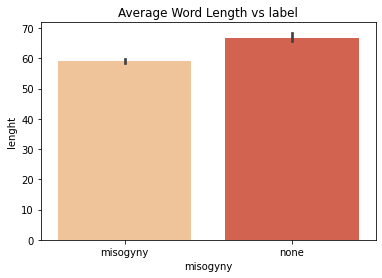

In [53]:
frame['lenght'] = frame['text'].apply(len)
fig1 = sns.barplot('misogyny','lenght',data = frame,palette="OrRd" )
plt.title('Average Word Length vs label')
plot = fig1.get_figure()
plot.savefig('Barplot.png')

In [54]:
import plotly.graph_objects as go

labels = frame['misogyny'].value_counts().keys()
values = df['misogyny'].value_counts()
# Plot pie chart 
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.show()

# Spliting the dataframe

In [56]:
import torch
import pytorch_lightning as pl

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [57]:
train, val = train_test_split(frame[['misogyny','text']], test_size=0.2, random_state=42)

train = train.rename(columns={'misogyny':"label"})
val = val.rename(columns={'misogyny':"label"})
lbl_enc = LabelEncoder()
train.loc[:,"label"] = lbl_enc.fit_transform(train["label"])
val.loc[:,"label"] = lbl_enc.transform(val["label"])
joblib.dump(lbl_enc,"label_encoder.pkl")
train.to_csv("train.csv",index=False)
val.to_csv("val.csv",index=False)

In [58]:
lbl_enc.classes_

array(['misogyny', 'none'], dtype=object)

# Creating the tensors to be input for the model

In [61]:
class ArabicDataset(Dataset):
    def __init__(self,data,max_len,model_type="Mini"):
        super().__init__()
        self.labels = data["label"].values
        self.texts = data["text"].values
        self.max_len = max_len
        model = {"Mini": "asafaya/bert-mini-arabic",
                "Medium": "asafaya/bert-medium-arabic",
                "Base": "asafaya/bert-base-arabic",
                "Large": "asafaya/bert-large-arabic"}
        self.tokenizer = AutoTokenizer.from_pretrained(model[model_type])
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self,idx):
        text = " ".join(self.texts[idx].split())
        label = self.labels[idx]
        inputs = self.tokenizer(text,padding='max_length',
                                max_length=self.max_len,truncation=True,return_tensors="pt")
        #input_ids,token_type_ids,attention_mask
        return {
            "inputs":{"input_ids":inputs["input_ids"][0],
                      "token_type_ids":inputs["token_type_ids"][0],
                      "attention_mask":inputs["attention_mask"][0],
                     },
            "labels": torch.tensor(label,dtype=torch.long) 
        }

In [62]:
class ArabicBertModel(pl.LightningModule):
    def __init__(self,model_type="Mini"):
        super().__init__()
        model = {"Mini": ("asafaya/bert-mini-arabic",256),
                "Medium": ("asafaya/bert-medium-arabic",512),
                "Base": ("asafaya/bert-base-arabic",768),
                "Large": ("asafaya/bert-large-arabic",1024)}
        self.bert_model = AutoModel.from_pretrained(model[model_type][0])
        self.fc = nn.Linear(model[model_type][1],18)
    
    def forward(self,inputs):
        out = self.bert_model(**inputs)#inputs["input_ids"],inputs["token_type_ids"],inputs["attention_mask"])
        pooler = out[1]
        out = self.fc(pooler)
        return out
    
    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=0.0001)
    
    def criterion(self,output,target):
        return nn.CrossEntropyLoss()(output,target)
    
    #TODO: adding metrics
    def training_step(self,batch,batch_idx):
        x,y = batch["inputs"],batch["labels"]
        out = self(x)
        loss = self.criterion(out,y)
        return loss
    
    def validation_step(self,batch,batch_idx):
        x,y = batch["inputs"],batch["labels"]
        out = self(x)
        loss = self.criterion(out,y)
        return loss

In [63]:
class ArabicDataModule(pl.LightningDataModule):
    def __init__(self,train_path,val_path,batch_size=12,max_len=100,model_type="Mini"):
        super().__init__()
        self.train_path,self.val_path= train_path,val_path
        self.batch_size = batch_size
        self.max_len = max_len
        self.model_type = model_type
    
    def setup(self,stage=None):
        train = pd.read_csv(self.train_path)
        val = pd.read_csv(self.val_path)
        self.train_dataset = ArabicDataset(data=train,max_len=self.max_len,model_type=self.model_type)
        self.val_dataset = ArabicDataset(data=val,max_len=self.max_len,model_type=self.model_type)
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset,batch_size=self.batch_size,shuffle=True,num_workers=4)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset,batch_size=self.batch_size,shuffle=False,num_workers=4)

# Setting some callbacks like early stoping and auto saving best models

In [64]:
import torch
from torch import nn,optim

from transformers import AutoTokenizer, AutoModel

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

In [66]:
#TODO: getting different models sizes results
MODEL_TYPE = "Medium"
dm = ArabicDataModule(train_path="./train.csv",
                val_path = "./val.csv",
                batch_size=128,max_len=60, model_type=MODEL_TYPE)

model = ArabicBertModel(model_type=MODEL_TYPE)
trainer = pl.Trainer(gpus=1,max_epochs=10, default_root_dir='.')
trainer.fit(model,dm)

Some weights of the model checkpoint at asafaya/bert-medium-arabic were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5684b1b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5684b1b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5684b1b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5684b1b90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

Validation: 0it [00:00, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5684b1b90>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5684b1b90>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5684b1b90>Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__

<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5684b1b90>Traceback (most recent call last):
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
self._shutdown_workers()    
Traceback (most recent call last):

self._shutdown_workers()Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/opt/conda/lib/p

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Model application on train data

In [67]:
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

preds = []
real_values = []

load = ArabicDataModule(train_path="./train.csv",
                           val_path = "./val.csv",
                batch_size=512,max_len=60)
load.setup()
train_dataloader = load.train_dataloader()

progress_bar = tqdm(range(len(train_dataloader)))

model.eval()
for batch in train_dataloader:    
    x,y = batch["inputs"],batch["labels"]
    inp = {k: v.to(device) for k, v in x.items()}
    
    with torch.no_grad():
        outputs = model(inp)

    predictions = torch.argmax(outputs, dim=-1)
    
    preds.extend(predictions)
    real_values.extend(y)

    progress_bar.update()
    
preds = torch.stack(preds).cpu()
real_values = torch.stack(real_values).cpu()

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/509 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/326k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

  0%|          | 0/23 [00:00<?, ?it/s]

In [69]:
from sklearn.metrics import classification_report

print(classification_report(real_values, preds, target_names=lbl_enc.classes_))

              precision    recall  f1-score   support

    misogyny       1.00      1.00      1.00      5919
        none       1.00      1.00      1.00      5737

    accuracy                           1.00     11656
   macro avg       1.00      1.00      1.00     11656
weighted avg       1.00      1.00      1.00     11656



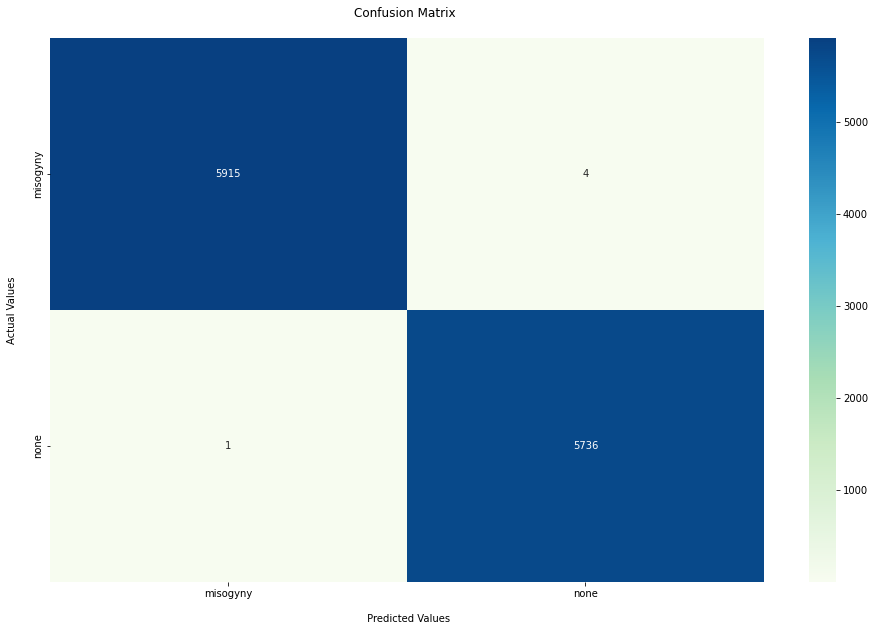

In [68]:
import sklearn.metrics as metrics

plt.figure(figsize=(16,10))
fx=sns.heatmap(metrics.confusion_matrix(real_values, preds), annot=True, fmt="d",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['misogyny', 'none'])
fx.yaxis.set_ticklabels(['misogyny', 'none'])
plt.show()

# Model application on test data

In [71]:
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

preds = []
real_values = []

load = ArabicDataModule(train_path="./train.csv",
                           val_path = "./val.csv",
                batch_size=512,max_len=60)
load.setup()
test_dataloader = load.val_dataloader()

progress_bar = tqdm(range(len(test_dataloader)))

model.eval()
for batch in test_dataloader:    
    x,y = batch["inputs"],batch["labels"]
    inp = {k: v.to(device) for k, v in x.items()}
    
    with torch.no_grad():
        outputs = model(inp)

    predictions = torch.argmax(outputs, dim=-1)
    
    preds.extend(predictions)
    real_values.extend(y)

    progress_bar.update()
    
preds = torch.stack(preds).cpu()
real_values = torch.stack(real_values).cpu()

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  0%|          | 0/6 [00:00<?, ?it/s]

In [72]:
from sklearn.metrics import classification_report

print(classification_report(real_values, preds, target_names=lbl_enc.classes_))

              precision    recall  f1-score   support

    misogyny       0.93      0.95      0.94      1452
        none       0.95      0.93      0.94      1462

    accuracy                           0.94      2914
   macro avg       0.94      0.94      0.94      2914
weighted avg       0.94      0.94      0.94      2914



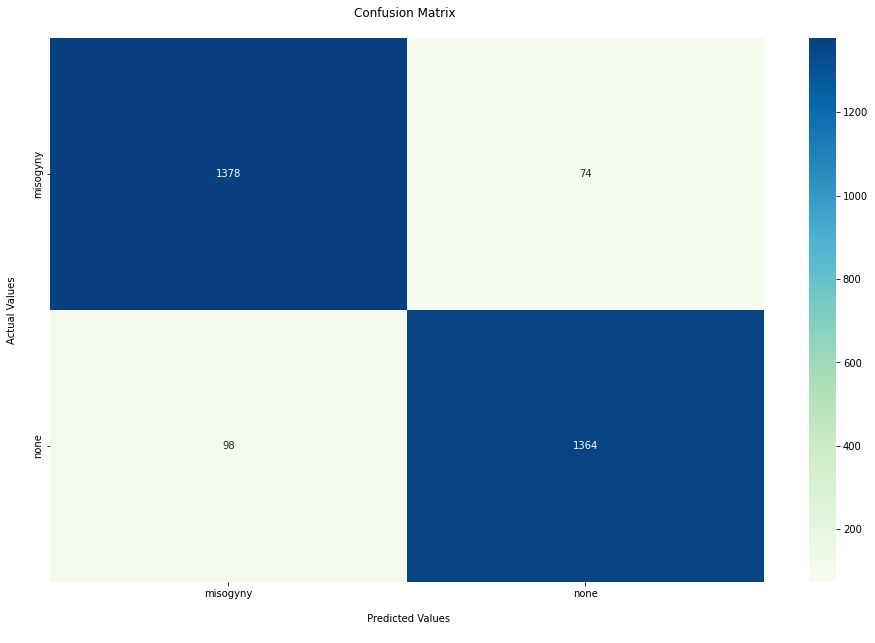

In [73]:
import sklearn.metrics as metrics

plt.figure(figsize=(16,10))
fx=sns.heatmap(metrics.confusion_matrix(real_values, preds), annot=True, fmt="d",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['misogyny', 'none'])
fx.yaxis.set_ticklabels(['misogyny', 'none'])
plt.show()

#   Machine Learning approach

In [75]:
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras import preprocessing as kprocessing
from tensorflow.keras import models, layers, optimizers

import transformers

# Visualization
from matplotlib import pyplot as plt

# Text processing
import re
import nltk
import gensim.downloader as api

# Various
from datetime import datetime

In [76]:
X_train, X_test, y_train, y_test = train_test_split(frame['text'], frame['misogyny'], test_size=0.2, random_state=42, stratify=frame['misogyny'])

In [77]:
corpus = X_train
# Initizalize the vectorizer with max nr words and ngrams (1: single words, 2: two words in a row)
vectorizer_tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,3))
# Fit the vectorizer to the training data
vectorizer_tfidf.fit(corpus)
TfidfVectorizer(max_features=20000, ngram_range=(1, 3))

TfidfVectorizer(max_features=20000, ngram_range=(1, 3))

# Logistic Rgression

In [78]:
classifier_tfidf = LogisticRegression()
model_tfidf = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", classifier_tfidf)])

start_time = datetime.now()
model_tfidf.fit(X_train, y_train)
end_time = datetime.now()

training_time_tfidf = (end_time - start_time).total_seconds()

In [79]:
predicted_train_tfidf = model_tfidf.predict(X_train)
accuracy_train_tfidf = accuracy_score(y_train, predicted_train_tfidf)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))

predicted_test_tfidf = model_tfidf.predict(X_test)
accuracy_test_tfidf = accuracy_score(y_test, predicted_test_tfidf)
accuracy_tfidf = accuracy_test_tfidf
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))

print('Training time: {:.1f}s'.format(training_time_tfidf))

Accuracy Training data: 95.8%
Accuracy Test data: 89.2%
Training time: 1.1s


# Rondom Forest

In [81]:
from sklearn.ensemble import RandomForestClassifier

classifier_tfidf = RandomForestClassifier(n_estimators=100)
model_tfidf = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", classifier_tfidf)])

start_time = datetime.now()
model_tfidf.fit(X_train, y_train)
end_time = datetime.now()

training_time_tfidf = (end_time - start_time).total_seconds()

In [82]:
predicted_train_tfidf = model_tfidf.predict(X_train)
accuracy_train_tfidf = accuracy_score(y_train, predicted_train_tfidf)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))

predicted_test_tfidf = model_tfidf.predict(X_test)
accuracy_test_tfidf = accuracy_score(y_test, predicted_test_tfidf)
accuracy_tfidf = accuracy_test_tfidf
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))

print('Training time: {:.1f}s'.format(training_time_tfidf))

Accuracy Training data: 99.8%
Accuracy Test data: 92.1%
Training time: 11.3s


# SVM

In [83]:
from sklearn import svm

classifier_tfidf = svm.SVC(kernel='linear')
model_tfidf = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", classifier_tfidf)])

start_time = datetime.now()
model_tfidf.fit(X_train, y_train)
end_time = datetime.now()

training_time_tfidf = (end_time - start_time).total_seconds()

In [84]:
predicted_train_tfidf = model_tfidf.predict(X_train)
accuracy_train_tfidf = accuracy_score(y_train, predicted_train_tfidf)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))

predicted_test_tfidf = model_tfidf.predict(X_test)
accuracy_test_tfidf = accuracy_score(y_test, predicted_test_tfidf)
accuracy_tfidf = accuracy_test_tfidf
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))

print('Training time: {:.1f}s'.format(training_time_tfidf))

Accuracy Training data: 98.0%
Accuracy Test data: 91.5%
Training time: 12.3s


# Naive bayes

In [85]:
from sklearn.naive_bayes import MultinomialNB
classifier_tfidf = MultinomialNB()
model_tfidf = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", classifier_tfidf)])

start_time = datetime.now()
model_tfidf.fit(X_train, y_train)
end_time = datetime.now()

training_time_tfidf = (end_time - start_time).total_seconds()

In [86]:
predicted_train_tfidf = model_tfidf.predict(X_train)
accuracy_train_tfidf = accuracy_score(y_train, predicted_train_tfidf)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))

predicted_test_tfidf = model_tfidf.predict(X_test)
accuracy_test_tfidf = accuracy_score(y_test, predicted_test_tfidf)
accuracy_tfidf = accuracy_test_tfidf
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))

print('Training time: {:.1f}s'.format(training_time_tfidf))

Accuracy Training data: 96.1%
Accuracy Test data: 90.1%
Training time: 1.0s


# GradientBoostingClassifier


In [87]:
from sklearn.ensemble import GradientBoostingClassifier
classifier_tfidf = GradientBoostingClassifier()
model_tfidf = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", classifier_tfidf)])

start_time = datetime.now()
model_tfidf.fit(X_train, y_train)
end_time = datetime.now()

training_time_tfidf = (end_time - start_time).total_seconds()

In [88]:
predicted_train_tfidf = model_tfidf.predict(X_train)
accuracy_train_tfidf = accuracy_score(y_train, predicted_train_tfidf)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))

predicted_test_tfidf = model_tfidf.predict(X_test)
accuracy_test_tfidf = accuracy_score(y_test, predicted_test_tfidf)
accuracy_tfidf = accuracy_test_tfidf
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))

print('Training time: {:.1f}s'.format(training_time_tfidf))

Accuracy Training data: 77.6%
Accuracy Test data: 76.9%
Training time: 5.0s


# LSTM

In [89]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.



In [90]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(frame['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 29654 unique tokens.


In [91]:
X = tokenizer.texts_to_sequences(frame['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (14570, 250)


In [92]:

Y = pd.get_dummies(frame['misogyny']).values
print('Shape of label tensor:', Y.shape)


Shape of label tensor: (14570, 2)


In [93]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(13113, 250) (13113, 2)
(1457, 250) (1457, 2)


In [95]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________
None


In [96]:
epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

2022-12-19 17:49:02.278296: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
185/185 [==============================] - 208s 1s/step - loss: 0.4887 - accuracy: 0.7521 - val_loss: 0.2714 - val_accuracy: 0.8918
Epoch 2/10
185/185 [==============================] - 202s 1s/step - loss: 0.1268 - accuracy: 0.9563 - val_loss: 0.1953 - val_accuracy: 0.9268
Epoch 3/10
185/185 [==============================] - 203s 1s/step - loss: 0.0302 - accuracy: 0.9919 - val_loss: 0.2134 - val_accuracy: 0.9337
Epoch 4/10
185/185 [==============================] - 203s 1s/step - loss: 0.0088 - accuracy: 0.9981 - val_loss: 0.2674 - val_accuracy: 0.9337
Epoch 5/10
185/185 [==============================] - 204s 1s/step - loss: 0.0060 - accuracy: 0.9988 - val_loss: 0.2501 - val_accuracy: 0.9352


In [97]:

accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

46/46 [==============================] - 3s 62ms/step - loss: 0.2014 - accuracy: 0.9341
Test set
  Loss: 0.201
  Accuracy: 0.934


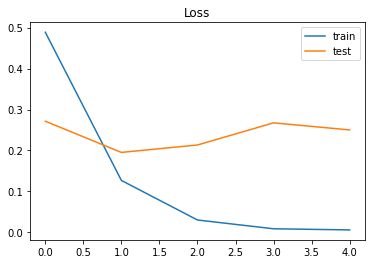

In [98]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

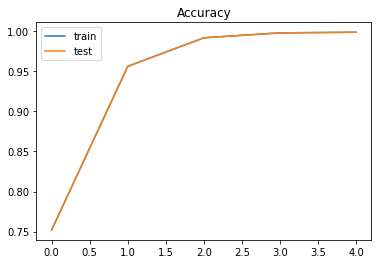

In [99]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['accuracy'], label='test')
plt.legend()
plt.show();

In [100]:
new_complaint = ['يدورو في العدل و المساواة و هما في ابسط مثال الخدمة و طلبات الموظفين كلهم يفضل العنصر النسائي و هما ياخدوهم قبل و من غير حتى مؤهلات اهم شي البندينات']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['misogyny','none']
print(pred, labels[np.argmax(pred)])

[[0.9975937  0.00212859]] misogyny
